<a href="https://colab.research.google.com/github/zrd123/my_colab/blob/master/code/Kaggle_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 下载数据集

In [ ]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [ ]:
def download(name, cache_dir=os.path.join('..', 'data')):
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [ ]:
def download_extract(name, folder=None):
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

# 读取数据集

In [ ]:
# !find / -name d2l

In [ ]:
# 如果没有安装pandas，请取消下一行的注释
# !pip install pandas
# !pip install d2l==0.17.6
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [ ]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [ ]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [ ]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [ ]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

# 数据预处理

In [ ]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean(skipna=True)) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [ ]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [ ]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

# 训练

In [ ]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

In [ ]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [ ]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

# K折交叉验证

In [ ]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [ ]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

# 模型选择

折1，训练log rmse0.126294, 验证log rmse0.147569
折2，训练log rmse0.121853, 验证log rmse0.149173
折3，训练log rmse0.122654, 验证log rmse0.149810
折4，训练log rmse0.127542, 验证log rmse0.134758
折5，训练log rmse0.119065, 验证log rmse0.161124
5-折验证: 平均训练log rmse: 0.123481, 平均验证log rmse: 0.148487


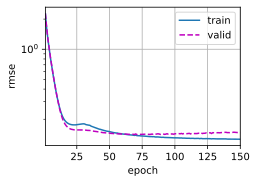

In [ ]:
k, num_epochs, lr, weight_decay, batch_size =5, 150, 6, 0.00005, 16
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [ ]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.134195


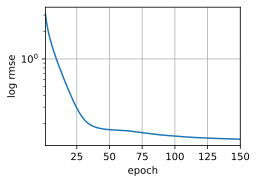

In [ ]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

# GPU

In [ ]:
import torch
from torch import nn

torch.device('cpu'), torch.device('cuda'), torch.device('cuda:1')

(device(type='cpu'), device(type='cuda'), device(type='cuda', index=1))

In [ ]:
torch.cuda.device_count()

1

In [ ]:
def try_gpu(i=0):
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def try_all_gpus():
    """返回所有可用的GPU，如果没有GPU，则返回[cpu(),]"""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

try_gpu(), try_gpu(10), try_all_gpus()

(device(type='cuda', index=0),
 device(type='cpu'),
 [device(type='cuda', index=0)])

In [ ]:
x = torch.tensor([1, 2, 3])
x.device

device(type='cpu')

In [ ]:
X = torch.rand(2, 3, device=try_gpu())
X

tensor([[0.1445, 0.1844, 0.4447],
        [0.1601, 0.9487, 0.3252]], device='cuda:0')

In [ ]:
Y = torch.rand(2, 3, device=try_gpu(1))
Y

tensor([[0.2244, 0.6515, 0.6614],
        [0.8368, 0.5690, 0.8943]])

In [ ]:
Z = X.cuda(0)
print(X)
print(Z)

tensor([[0.1445, 0.1844, 0.4447],
        [0.1601, 0.9487, 0.3252]], device='cuda:0')
tensor([[0.1445, 0.1844, 0.4447],
        [0.1601, 0.9487, 0.3252]], device='cuda:0')


In [ ]:
X + Z

tensor([[0.2891, 0.3687, 0.8894],
        [0.3202, 1.8975, 0.6505]], device='cuda:0')

In [ ]:
Z.cuda(0) is Z

True

## 神经网络

In [ ]:
net = nn.Sequential(nn.Linear(3, 1))
net = net.to(device=try_gpu())

In [ ]:
net(X)

tensor([[0.3220],
        [0.6085]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
net[0].weight.data.device

device(type='cuda', index=0)

# autogluon

In [ ]:
!pip install autogluon

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor

train_data = TabularDataset("train.csv")

# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = train_data.dtypes[train_data.dtypes != 'object'].index
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
train_data[numeric_features] = train_data[numeric_features].fillna(0)

id, label = "Id", "SalePrice"
predictor = TabularPredictor(label = label).fit(train_data.drop(columns=[id]))

Loaded data from: train.csv | Columns = 81 / 81 | Rows = 1460 -> 1460
No path specified. Models will be saved in: "AutogluonModels/ag-20231003_113148/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231003_113148/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
Disk Space Avail:   49.01 GB / 83.96 GB (58.4%)
Train Data Rows:    1460
Train Data Columns: 79
Label Column: SalePrice
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (755000, 34900, 180921.19589, 79442.50288)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Genera

[1000]	valid_set's rmse: 26659.7
[2000]	valid_set's rmse: 26391.7
[3000]	valid_set's rmse: 26328.2
[4000]	valid_set's rmse: 26323.7


	-26322.2726	 = Validation score   (-root_mean_squared_error)
	6.71s	 = Training   runtime
	0.23s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 29122.4
[2000]	valid_set's rmse: 28482.9
[3000]	valid_set's rmse: 28351.6
[4000]	valid_set's rmse: 28302.3
[5000]	valid_set's rmse: 28295.2
[6000]	valid_set's rmse: 28293.5
[7000]	valid_set's rmse: 28293
[8000]	valid_set's rmse: 28292.8
[9000]	valid_set's rmse: 28292.8
[10000]	valid_set's rmse: 28292.8


	-28292.8198	 = Validation score   (-root_mean_squared_error)
	29.16s	 = Training   runtime
	0.88s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-32503.5203	 = Validation score   (-root_mean_squared_error)
	7.45s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: CatBoost ...
	-29103.7019	 = Validation score   (-root_mean_squared_error)
	102.96s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-31961.8029	 = Validation score   (-root_mean_squared_error)
	2.43s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-35565.5911	 = Validation score   (-root_mean_squared_error)
	4.47s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: XGBoost ...
	-26948.4583	 = Validation score   (-root_mean_squared_error)
	6.26s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-34491.1186	 = Validation score   (-root_mean_squared_error)
	6.82s	 = Training   run

[1000]	valid_set's rmse: 31903.8


	-31878.6086	 = Validation score   (-root_mean_squared_error)
	14.37s	 = Training   runtime
	0.22s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-25504.3871	 = Validation score   (-root_mean_squared_error)
	0.76s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 189.25s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20231003_113148/")


In [ ]:
import pandas as pd
test_data = TabularDataset("test.csv")

# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = test_data.dtypes[test_data.dtypes != 'object'].index
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
test_data[numeric_features] = test_data[numeric_features].fillna(0)

preds = predictor.predict(test_data.drop(columns=[id]))
submission = pd.DataFrame({id:test_data[id], label:preds})
submission.to_csv("submission.csv", index=False)

Loaded data from: test.csv | Columns = 80 / 80 | Rows = 1459 -> 1459
